<a href="https://colab.research.google.com/github/vitaliy-sharandin/data_science_projects/blob/master/portfolio/regression/Energy_price_demand_and_potential_supply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Articles
#### Green energy articles

* Wind and solar power capacity Poland <br>
https://www.statista.com/statistics/1003492/poland-wind-and-solar-power-capacity-forecast/

* Predict solar energy <br>
* https://towardsdatascience.com/predicting-solar-power-output-using-machine-learning-techniques-56e7959acb1f <br>
* https://www.omnicalculator.com/ecology/solar-panel#:~:text=To%20find%20the%20solar%20panel,day%20is%20just%20an%20average.

* Wind electric power atlas <br>
https://globalwindatlas.info/en/area/Poland/Ma%C5%82opolskie


#### Energy consumption prediction articles
* https://towardsdatascience.com/forecasting-energy-consumption-using-neural-networks-xgboost-2032b6e6f7e2
* https://towardsdatascience.com/introduction-to-global-forecasting-models-3ca8e69a6524
* https://www.neuraldesigner.com/blog/electricity_demand_forecasting#PredictiveModel

# Data
#### Energy
* Energy
    * Krakow GUS https://krakow.stat.gov.pl/
    * Tauron
    * Ministerstwo klimatu https://www.gov.pl/web/klimat
* Weather
    * Krakow https://www.visualcrossing.com/weather/weather-data-services


# Solution
* EDA
  * https://towardsdatascience.com/how-to-do-an-eda-for-time-series-cbb92b3b1913
  * https://datastud.dev/posts/time-series-eda
* Model
  * Cloud
    * https://www.run.ai/guides/automl/automl-solutions
    * https://cloud.google.com/automl
    * https://www.datarobot.com/
  * Manual
    * https://forecastegy.com/posts/multivariate-time-series-forecasting-in-python/
    * https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
    * https://unit8co.github.io/darts/

# Constructing dataset
To create an energy demand prediction model we need a dataset with following variables:
* Features
  * Weather data: Temperature, humidity, rainfall
  * Price of electricity
  * Demographics: number of people
* Target variable
  * Energy consumption kWh

# TODO

1.   Try solving with framework: mlforecast, kats, darts
2.   Try using real Krk data

#### EDA

In [1]:
!pip install -U -q datasets
!pip install -U -q dataprep
!pip install -U -q feature_engine
!pip install -U -q Boruta
!pip install -U -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.0/764.0 kB 34.5 MB/s eta 0:0

In [2]:
from datasets import load_dataset
from dataprep.eda import *
import pandas as pd
import missingno as msno
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
energy_consumption_dataset = load_dataset("vitaliy-sharandin/energy-consumption-hourly-spain")
energy_consumption_weather_dataset = load_dataset("vitaliy-sharandin/energy-consumption-weather-hourly-spain")
energy_df = energy_consumption_dataset['train'].to_pandas()
weather_df = energy_consumption_weather_dataset['train'].to_pandas()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

#### Cleaning energy dataset

In [4]:
# create_report(energy_df)

In [5]:
# msno.heatmap(energy_df,figsize=(12,5))
# msno.matrix(energy_df,figsize=(24,5))

In [6]:
energy_df.dropna(subset='total load actual',inplace=True)
energy_df.drop(['generation hydro pumped storage aggregated','forecast wind offshore eday ahead','price day ahead','total load forecast'], axis=1, inplace=True)

In [7]:
target = 'total load actual'
categorical_numeric = [var for var in energy_df.columns if energy_df[var].dtype!='O' and var!=target and energy_df[var].nunique()<10]
continuous = [var for var in energy_df.columns if energy_df[var].dtype!='O' and var!=target and var not in categorical_numeric]
mixed = [var for var in energy_df.columns if pd.api.types.infer_dtype(energy_df[var]) == 'mixed']
categorical_object = [var for var in energy_df.columns if energy_df[var].dtype=='O' and var not in mixed]
sorted_features = [target]+categorical_numeric+continuous+categorical_object+mixed

In [8]:
energy_df[categorical_numeric+continuous]=energy_df[categorical_numeric+continuous].fillna(energy_df[categorical_numeric+continuous].mean())
energy_df = energy_df.set_index('time')
energy_df.index = pd.to_datetime(energy_df.index,utc=True)

#### Cleaning and flattening weather dataset

In [9]:
# create_report(weather_df)

In [10]:
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'],utc=True)
weather_df.drop(['rain_3h','weather_main','weather_icon'], axis=1, inplace=True)
weather_df = weather_df[weather_df['dt_iso'].isin(energy_df.index) & (~weather_df.duplicated(['dt_iso','city_name']))]

In [11]:
weather_df = weather_df.set_index(['dt_iso','city_name'])
weather_df = weather_df.unstack('city_name')
weather_df.columns = ['_'.join(col).strip() for col in weather_df.columns.values]

#### Merging energy and weather dataset

In [22]:
energy_weather_df = energy_df.join(weather_df, how='inner')

# Feature selection and engineering

#### Transforming variables

In [13]:
target = 'total load actual'
categorical_numeric = [var for var in energy_weather_df.columns if energy_weather_df[var].dtype!='O' and var!=target and energy_weather_df[var].nunique()<10]
continuous = [var for var in energy_weather_df.columns if energy_weather_df[var].dtype!='O' and var!=target and var not in categorical_numeric]
mixed = [var for var in energy_weather_df.columns if pd.api.types.infer_dtype(energy_weather_df[var]) == 'mixed']
categorical_object = [var for var in energy_weather_df.columns if energy_weather_df[var].dtype=='O' and var not in mixed]
sorted_features = [target]+categorical_numeric+continuous+categorical_object+mixed

X_train, X_test, y_train, y_test = train_test_split(
    energy_weather_df[energy_weather_df.columns.difference([target])],  # predictors
    energy_weather_df[target],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=42,
    shuffle=False
)

encoder = OrdinalEncoder(
    variables=categorical_object,
    encoding_method='ordered'
)

X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.fit_transform(X_test, y_test)

#### Boruta feature selection

In [14]:
# %%time
# lgb_regressor = lgb.LGBMRegressor()

# feat_selector = BorutaPy(lgb_regressor, n_estimators='auto', random_state=42)
# feat_selector.fit(X_train.values, y_train.values)
# selected_rf_features = pd.DataFrame({'Feature':list(X_train.columns),
#                                        'Ranking':feat_selector.ranking_}).sort_values(by='Ranking')
# selected_rf_features.nsmallest(40, 'Ranking').plot.barh(x='Feature',figsize=(24,5))

# Model manual selection

#### Finding optimal model and hyperparameters

In [15]:
# %%time
# warnings.filterwarnings('ignore')

# def objective(trial):

#     model_name = trial.suggest_categorical("classifier", ['LGBM', 'XGBoost'])

#     if model_name == "LGBM":
#       params = {
#         "objective": "regression",
#         "metric": "rmse",
#         "n_estimators": 1000,
#         "verbosity": -1,
#         "bagging_freq": 1,
#         "learning_rate": trial.suggest_float("learning_rate_light", 1e-3, 0.1, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
#         "subsample": trial.suggest_float("subsample_light", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree_light", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#       }
#       model = lgb.LGBMRegressor(**params)

#     elif model_name == "XGBoost":
#       params = {
#       'max_depth': trial.suggest_int('max_depth', 1, 10),
#       'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
#       'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#       'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#       'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#       'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
#       'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
#       'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#       'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#       'eval_metric': 'rmse',
#       'use_label_encoder': False
#       }
#       model = xgb.XGBRegressor(**params)

#     time_split = TimeSeriesSplit(n_splits=10)
#     score = cross_val_score(model, X_train, y_train, cv=time_split, scoring='neg_root_mean_squared_error')
#     average_score = score.mean() * -1

#     return average_score

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50, show_progress_bar=True)

# display(study.best_params)
# display(study.best_value)

#### Testing selected model

In [19]:
params = {
        "objective": "regression",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        'learning_rate': 0.020287507534838184,
        'num_leaves': 815,
        'subsample': 0.2292262066384843,
        'colsample_bytree': 0.6216522835855189,
        'min_data_in_leaf': 33
        }
model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test.values)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
RMSE: 1430.9919630752688


In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(40).plot(kind='barh')

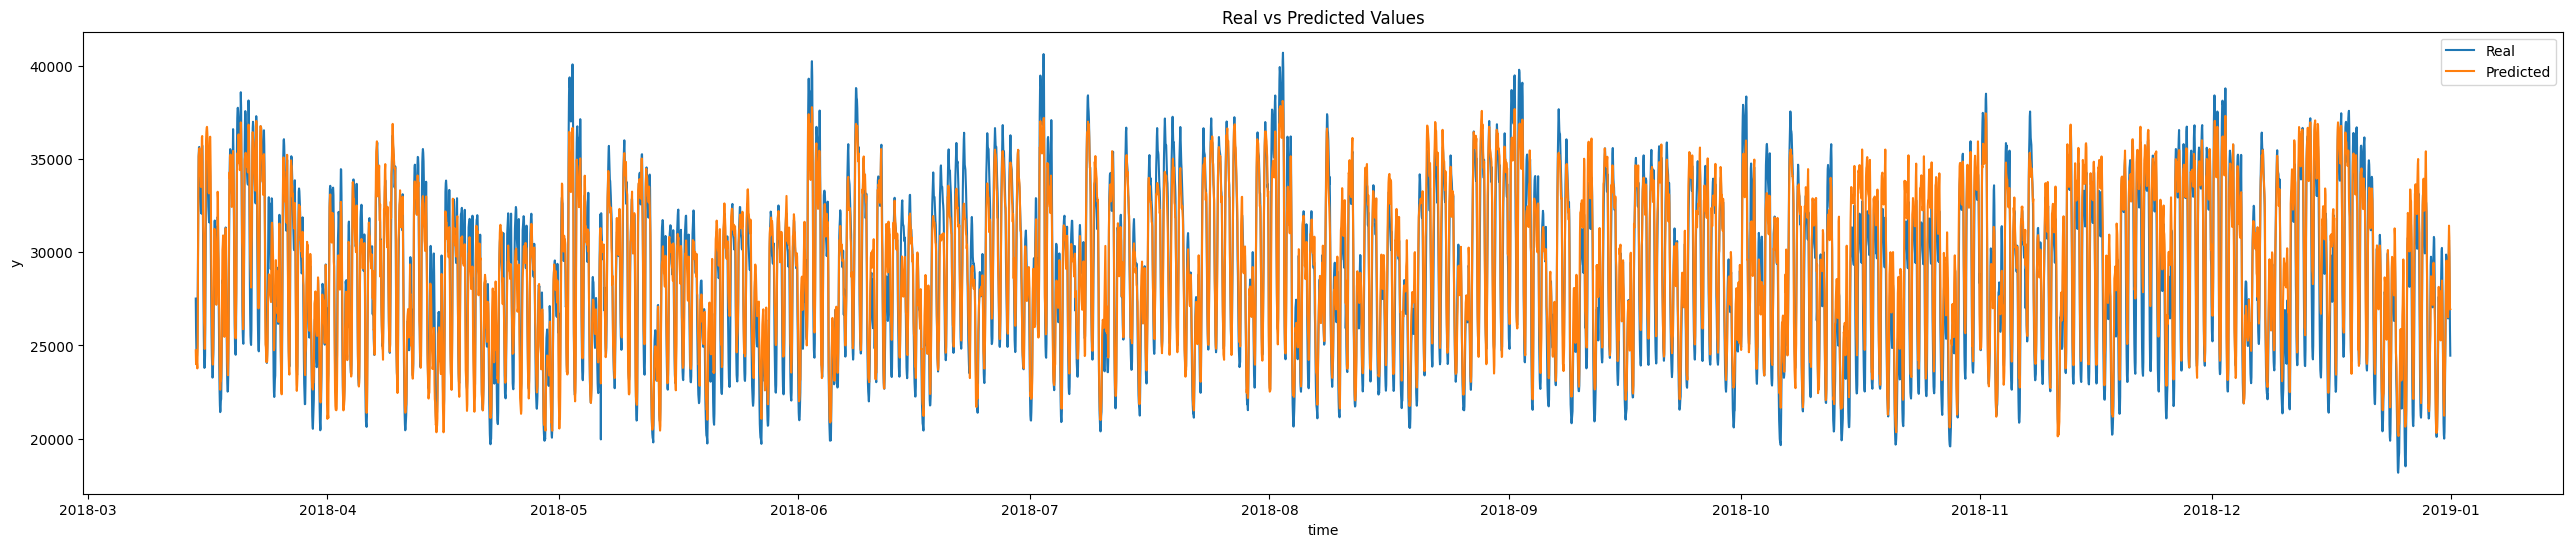

In [41]:
plt.figure(figsize=(32, 6))
sns.lineplot(x=X_test.index, y=y_test, label='Real')
sns.lineplot(x=X_test.index, y=y_pred, label='Predicted')
plt.title('Real vs Predicted Values')
plt.legend()
plt.show()

# MLForecast framework implementation

In [48]:
!pip install -U -q mlforecast
!pip install -U -q datasetsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.6/287.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 12.7 MB/s eta 0:00:00


In [50]:
from mlforecast import MLForecast
from datasetsforecast.losses import rmse

In [92]:
energy_weather_df_mlforecast = energy_weather_df.copy()
energy_weather_df_mlforecast['unique_id'] = 'Energy_weather_Spain'
energy_weather_df_mlforecast['ds'] = energy_weather_df_mlforecast.index.tz_localize(None)
energy_weather_df_mlforecast = energy_weather_df_mlforecast.rename(columns={'total load actual':'y'})

In [99]:
train = energy_weather_df_mlforecast[:-168]
test = energy_weather_df_mlforecast[-168:]

encoder = OrdinalEncoder(
    variables=categorical_object,
    encoding_method='ordered'
)

train = encoder.fit_transform(train, train['y'])
test = encoder.fit_transform(test, test['y'])

In [62]:
%%time
warnings.filterwarnings('ignore')

def objective(trial):

    model_name = trial.suggest_categorical("classifier", ['LGBMRegressor', 'XGBRegressor'])

    if model_name == "LGBMRegressor":
      params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate_light", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample_light", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree_light", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
      }
      model = lgb.LGBMRegressor(**params)

    elif model_name == "XGBRegressor":
      params = {
      'max_depth': trial.suggest_int('max_depth', 1, 10),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
      'n_estimators': trial.suggest_int('n_estimators', 50, 500),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
      'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
      'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
      'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
      'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
      'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
      'eval_metric': 'rmse',
      'use_label_encoder': False
      }
      model = xgb.XGBRegressor(**params)

    ml_forecast = MLForecast(models=[model],
                   freq='H',
                   lags=[1,2,12,24,168],
                   date_features=['hour','day','week', 'month'],
                   num_threads=6)

    crossvalidation_df = ml_forecast.cross_validation(
                                                      data=X_train,
                                                      window_size=168,
                                                      n_windows=3,
                                                    )
    rmse = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(lambda df: rmse(df['y'], df[model_name])).mean()

    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

display(study.best_params)
display(study.best_value)

[I 2023-08-05 18:59:56,320] A new study created in memory with name: no-name-719cf9f6-9ef7-4baf-97bc-11e04add1042


  0%|          | 0/50 [00:00<?, ?it/s]

[W 2023-08-05 19:02:27,205] Trial 0 failed with parameters: {'classifier': 'XGBRegressor', 'max_depth': 6, 'learning_rate': 0.19242503412835169, 'n_estimators': 340, 'min_child_weight': 10, 'gamma': 0.01300069837587236, 'subsample': 0.769966173410886, 'colsample_bytree': 0.010498898191767707, 'reg_alpha': 0.0004813524281848112, 'reg_lambda': 0.0016703113865075814} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<timed exec>", line 44, in objective
  File "/usr/local/lib/python3.10/dist-packages/mlforecast/utils.py", line 186, in inner
    return f(*new_args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/mlforecast/forecast.py", line 685, in cross_validation
    y_pred = self.predict(
  File "/usr/local/lib/python3.10/dist-packages/mlforecast/utils.py", line 186, in inner
    return f(*new_args, 

KeyboardInterrupt: ignored

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


3758.58808865086

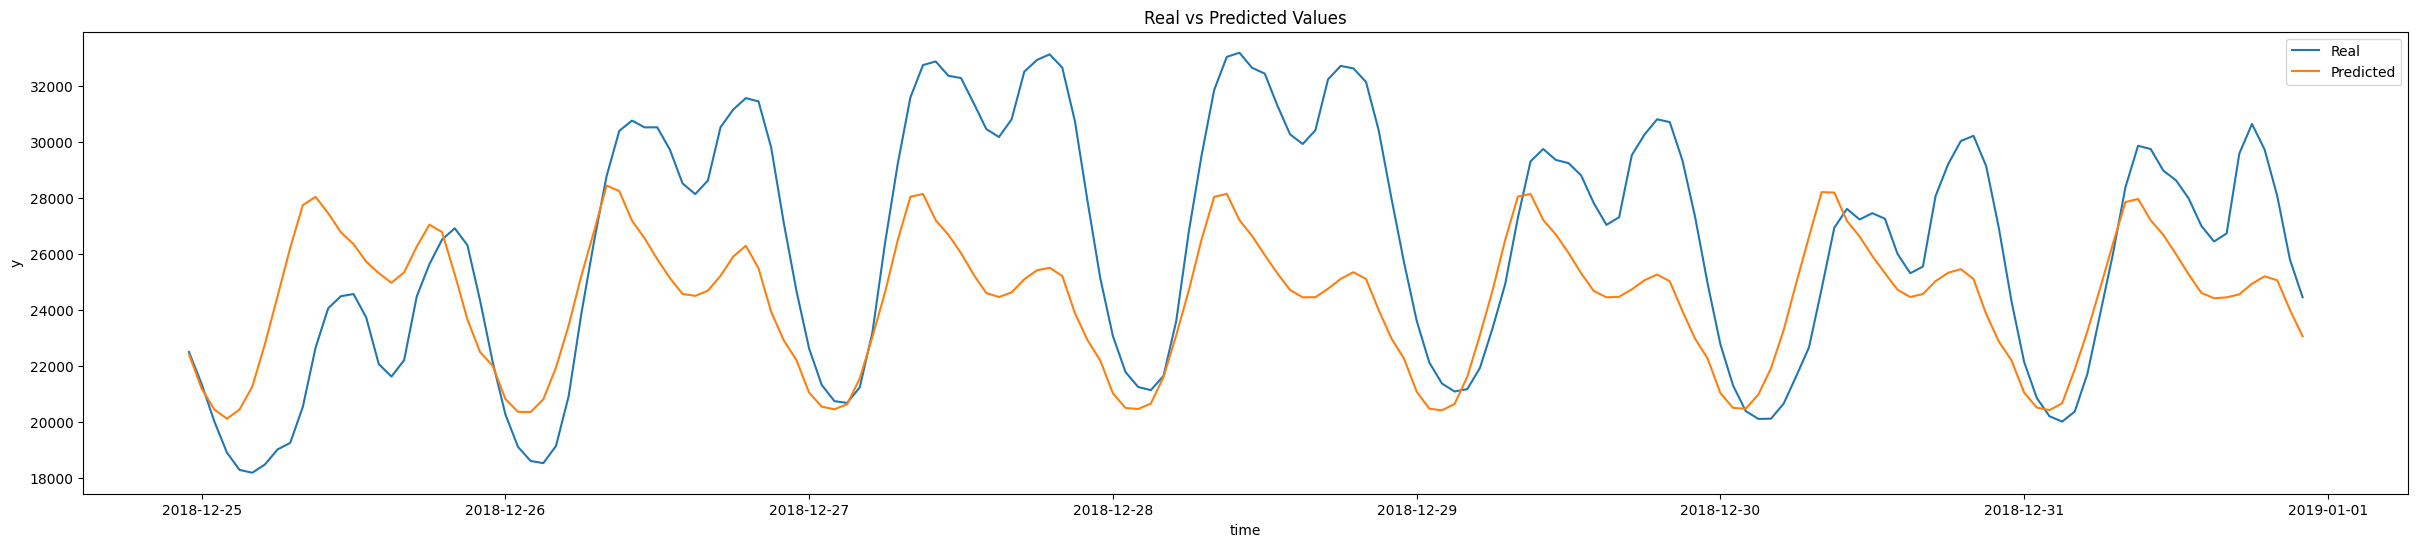

<Axes: title={'center': 'Feature Importance LGBMRegressor'}>

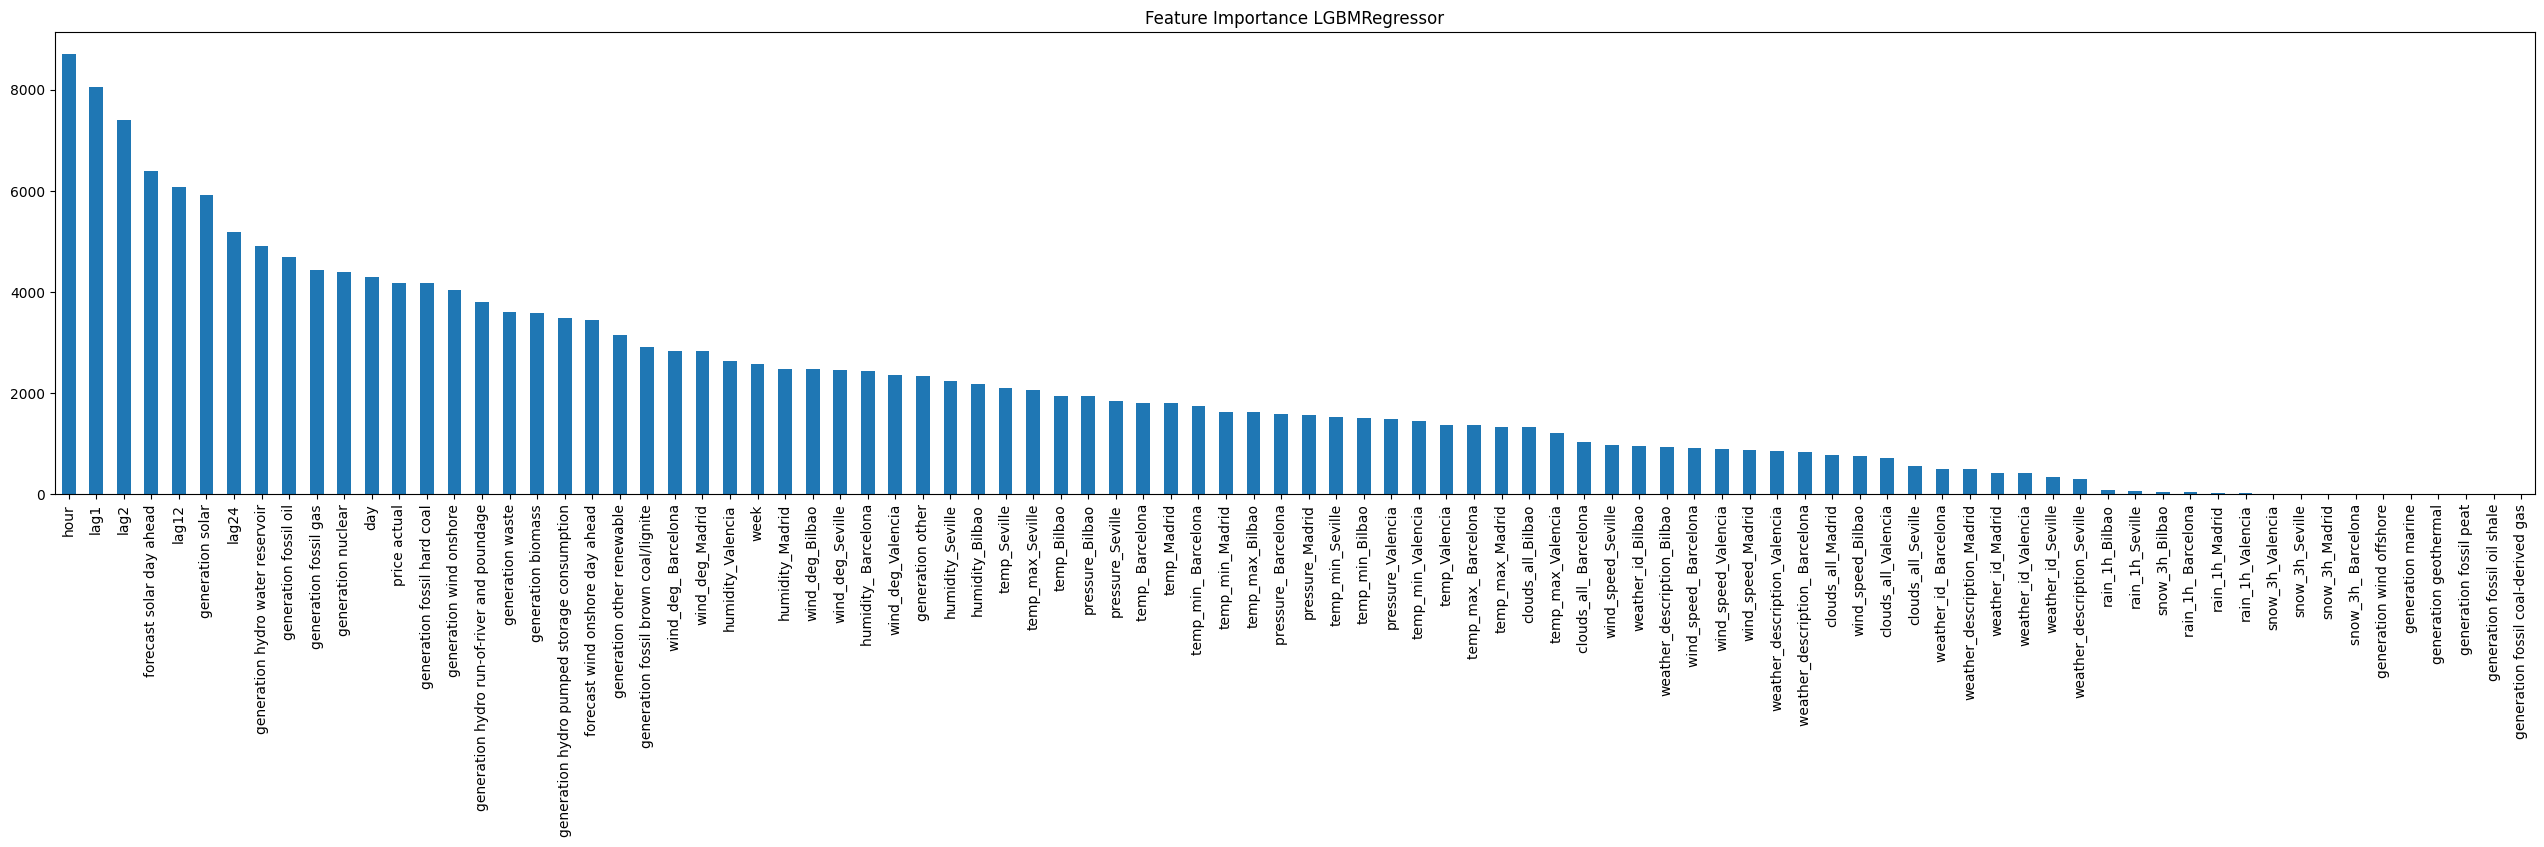

In [104]:
# Test a model
ml_forecast = MLForecast(models=[model],
                   freq='H',
                   lags=[1,2,12,24],
                   date_features=['hour','day','week'],
                   num_threads=6)

ml_forecast.fit(X_train)
y_pred = ml_forecast.predict(len(test.index))

display(mean_squared_error(test['y'], y_pred['LGBMRegressor'], squared=False))

plt.figure(figsize=(30, 6))
sns.lineplot(x=test.index, y=test['y'], label='Real')
sns.lineplot(x=test.index, y=y_pred['LGBMRegressor'], label='Predicted')
plt.title('Real vs Predicted Values')
plt.legend()
plt.show()

pd.Series(ml_forecast.models_['LGBMRegressor'].feature_importances_, index=ml_forecast.ts.features_order_).sort_values(ascending=False).plot.bar(figsize=(32, 6),title='Feature Importance LGBMRegressor')